# Lab 7 - Model Deployment
In this lab we'll deploy the financial news sentiment classification network that we built last week so that it's usable via the internet.

The model will be hosted on Microsoft's cloud hosting service _Azure_, where we will run a web server which receives and processes predictions requests over the web via HTTP.

## Mount Your Google Drive Storage

Same as the last lab, we'll be mounting our Google Drive storage for access within this notebook.

Run the next cell and follow the instructions to give Colaboratory access to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Once you've authorised Colaboratory, open the Files tab 📁 on the left and navigate to the directory for this lab. Then, right click on it and select "copy path".


<font color="red">In the next cell, paste the path to your directory.</font>

_The path should look like `/content/drive/My_Drive/...`_

In [1]:
import os
lab_dir = "YOUR_DIR_HERE"

# SOLUTION LINE
#lab_dir = "/content/drive/My Drive/CSE5DL/lab07"

Now we'll navigate to that directory and print out the files to check that we're in the right place.

<font color="red">Run the next cell and confirm that you see the files you uploaded for this lab.</font>

_If you don't see the lab files, you're in the wrong directory - try finding and copying the path again._

In [ ]:
# Change Python's current working directory
os.chdir(lab_dir)
# Print the name and contents of the current working directory
!pwd
!ls -al

## Project Structure
You'll notice that although we're using the same model as last lab, the project structure is quite different. We'll learn about the files one at a time as we progress through the lab.

## Register to use Microsoft Azure
As our model will be hosted on the Microsoft Azure Machine Learning service, you will first need to register an account using your La Trobe University credentials.

To begin, visit [portal.azure.com](https://portal.azure.com) and log in using your La Trobe credentials.


## Sign up for a Free Subscription
Before we can use Azure, we first need to sign up for a free subscription.

From [the portal](https://portal.azure.com), click "Subscriptions" to view the subscriptions associated with your account.
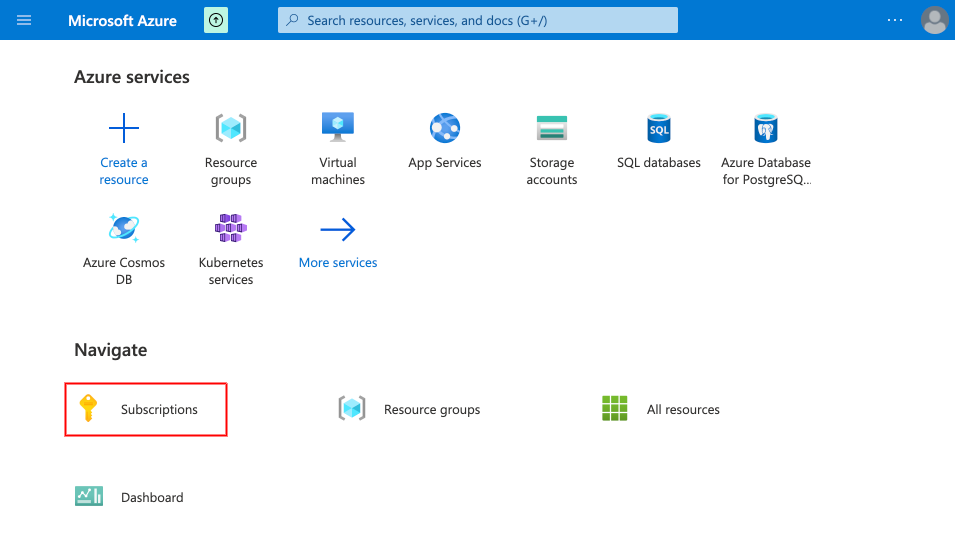

Click on "Add" in the top-left hand corner to add a new subscription.
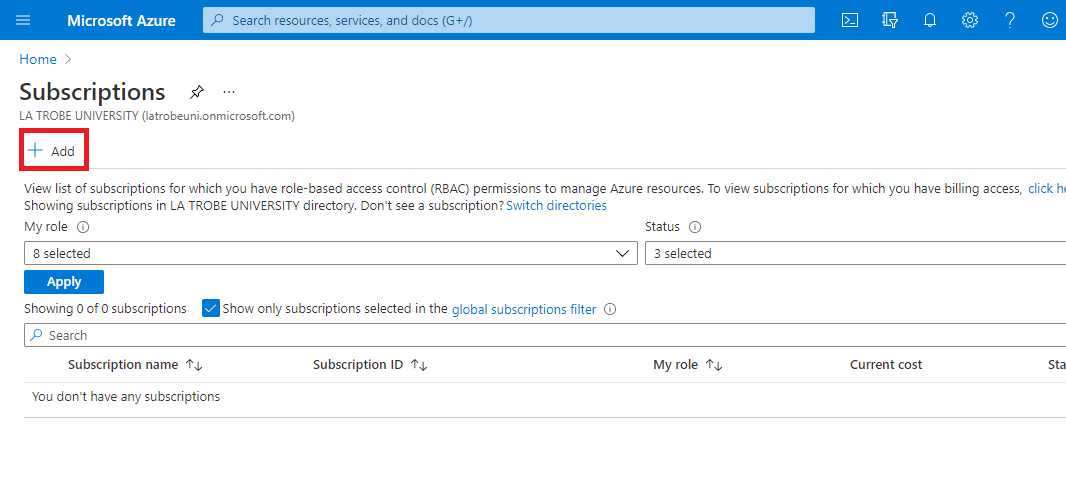

This will direct you to a new page. You may be prompted for your password again.  
Once the new page loads, select the "Azure for Students" subscription.
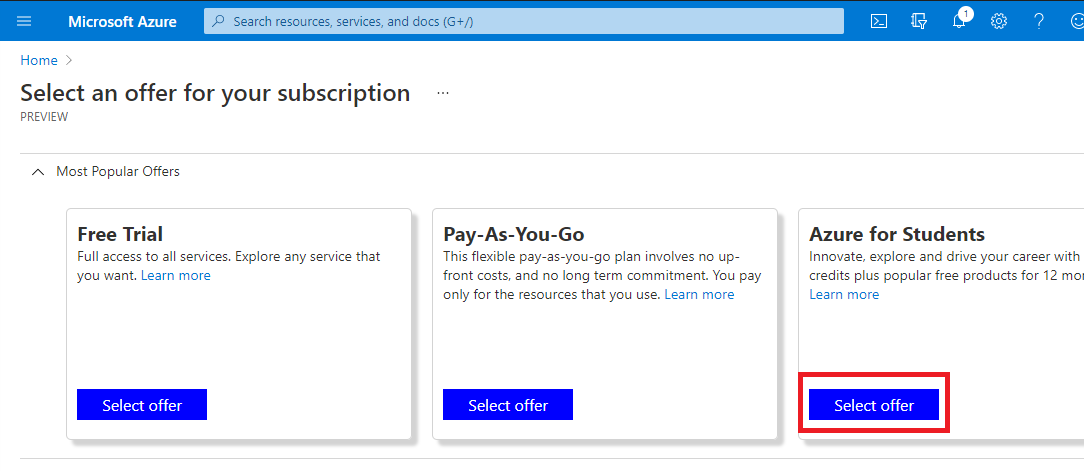

This will take you to a new page again, where you can click on "Start free".
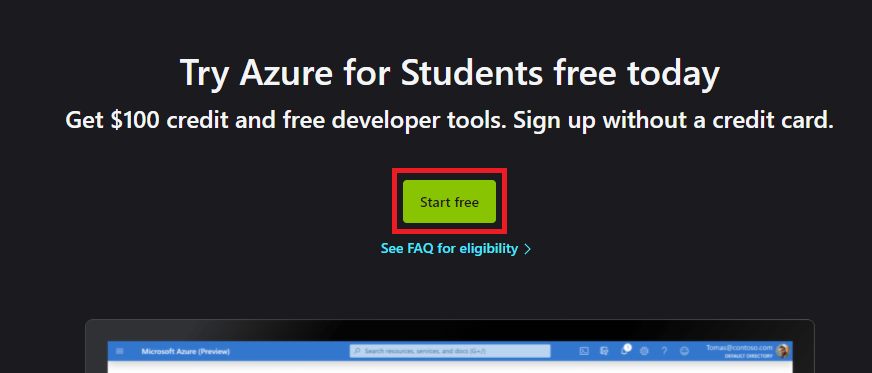

To verify yourself, you will be asked to receive a text message verification.
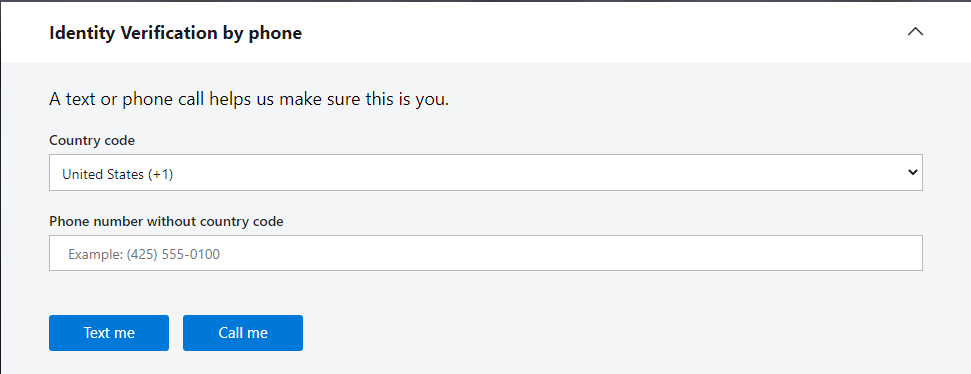

Once verified, you then need to provide your details to sign up for the subscription.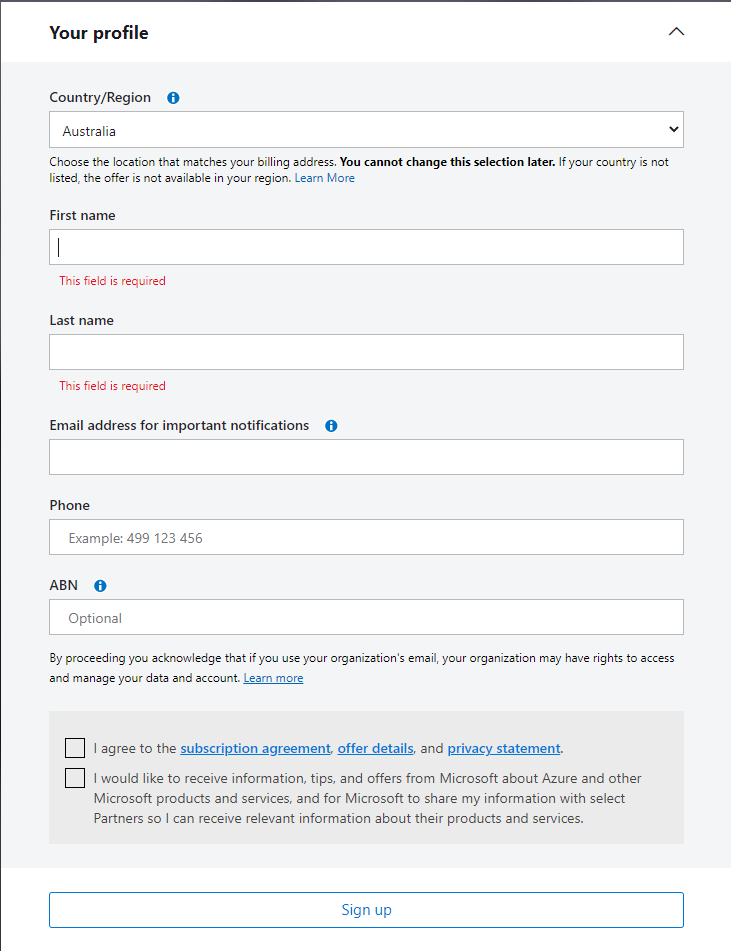


Once you complete the sign up process you will be redirected to a new page again where you will need to wait a few moments for your subscription to be activated.  
Once activated, proceed to the following section. 

### Copy your Subscription ID
In order to interact with Azure using Python, we need to take note of the subscription ID you're using. From [the portal](https://portal.azure.com), click "Subscriptions" to view the subscriptions assosiated with your account.
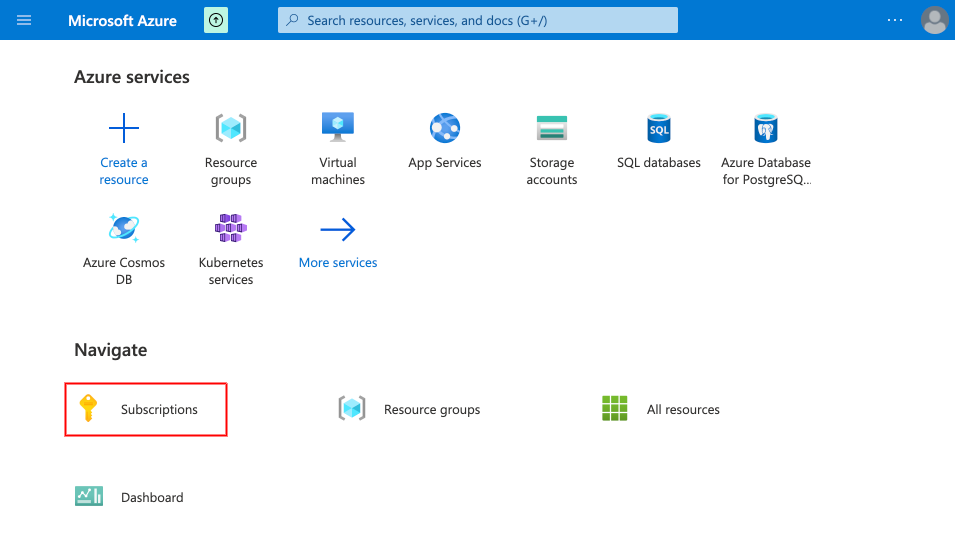

Then, double click to select your subscription ID, then copy it to the clipboard.

_You may have more than one subsription if you've used Azure before. If so, select the subscription that relates to this subject._

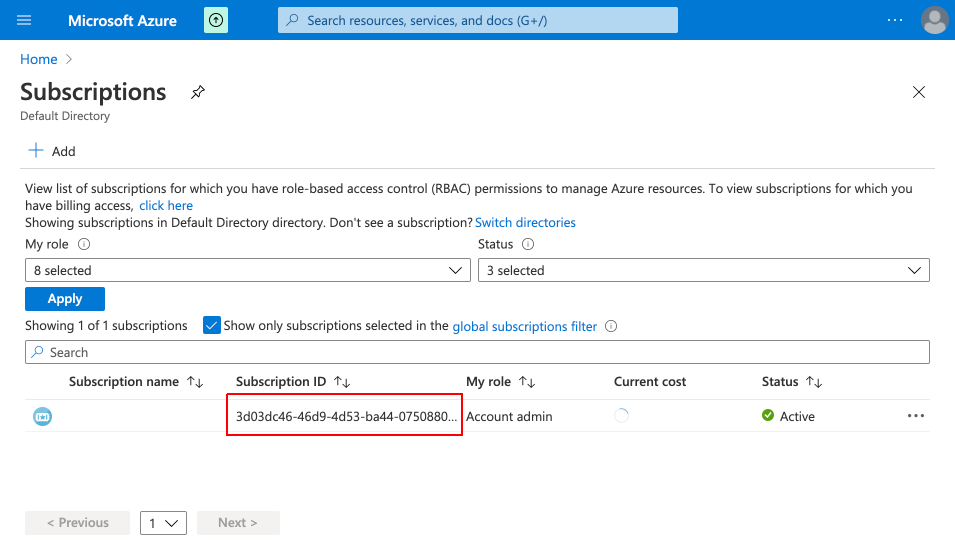

Paste your subscription ID below.

In [4]:
SUBSCRIPTION_ID = "ID_GOES_HERE"

### Export model
Although it's possible to do some model deployment via the Azure portal, it's more convenient to use the Python SDK (Software Development Kit), as it's faster and easily reproducible. Thus, we first need to install the Azure SDK using `pip`.

Run the next cell to install two Python libraries locally:
 * `azureml-core`: the SDK for managing machine learning tasks on Azure.
 * `flask-ngrok`: a tool that helps with web-hosting - we'll discuss this a little later.

In [ ]:
!pip install -qr requirements.txt

With the Azure SDK installed, we have the ability to provision compute resources and manage machine learning tasks - all in Python.

### Create a Workspace
A workspace is a top-level container for Azure machine learning projects. It houses models, services, scripts, and much more. The first step is therefore to create a workspace for this project.

A workspace must belong to a "resource group", which is a container for resources that don't necessarily relate to machine learning. A resource group will be automatically created for us when we create a workspace, so we don't need to be too concerned with it.

<font color="red">Run the next cell to create a workspace and its containing resource group. Follow the instructions presented to copy and paste an authorisation code in another tab, and log in with your student account.</font>

_This operation may take a few minutes, so be patient._

In [ ]:
from azureml.core import Workspace

try:
    # Try to get the workspace in case it was previously created
    workspace = Workspace.get(
        name='cse5dl-lab07',
        subscription_id=SUBSCRIPTION_ID,
        resource_group='cse5dl')
except:
    # If that fails, create the workspace
    workspace = Workspace.create(
        name='cse5dl-lab07',
        subscription_id=SUBSCRIPTION_ID,
        resource_group='cse5dl',
        create_resource_group=True,
        location='eastus2')

### Register the Model
The last lab finished with a transformer network trained for sentiment classification. To begin, copy the saved weights file (`transformer.pth`) from the transformer NLP lab into this lab's `model_weights` directory. This can be done using the regular Google Drive [web interface](https://drive.google.com/drive/my-drive).

_If you don't have the weights from last lab, you can download a copy [here](https://drive.google.com/file/d/17bSh7IBawo_cDqiWqGQY60zIFid8J5LW/view?usp=sharing)._

Once that's done, we need to register the model with Azure. In doing so, a copy of the model weights is uploaded and tagged. Azure allows for versioning model weights, but that's beyond the scope of this lab.

<font color="red">Run the next cell to register the model in your workspace. This may take a few minutes depending on internet speed.</font>

In [ ]:
from azureml.core.model import Model

try:
    # Try to get the model from the workspace in case it was already registered
    model = Model.list(workspace=workspace)[-1]
except:
    # If that fails, register the model for the first time 
    model = Model.register(
        workspace=workspace,
        model_path='./model_weights/',
        model_name='news-sentiment-classifier',
        description='Natural language sentiment classification model trained on financial news titles')

### Inference Configuration
The server will process requests in whichever manner we desire, so it's up to us to describe how the server works; this is done with an `InferenceConfig`.

You'll notice in the next cell that we refer to two files: `inference.py` and `myenv.yml`. Read the descriptions below, then open each of the files using the files tab on the left, and read through them.

__inference.py__ \
This script is the minimal instructions required for making predictions with our model. Azure requires that it have two functions:
 * `init`: This function is called when the server is started, and should prepare the model for inference.
 * `run`: This function is called when any requests are received, and is to return the model's prediction given the inputs.

Usage is something like this:
```python
import inference
inference.init()
inference.run('Stock market good')
inference.run('Stock market bad')
...
```

__myenv.yml__ \
This is a [Conda](https://docs.conda.io/) configuration file which is used to describe our project dependencies. When we provision our resources, a [Docker](https://www.docker.com/) image is created and our dependencies installed. You'll notice that we have only a few dependencies as it's what's required for performing model inference and nothing more.

<font color="red">Run the next cell to create the inference configuration</font>

In [8]:
from azureml.core.model import InferenceConfig

# Combine scoring script and environment in inference configuration
inference_config = InferenceConfig(
    runtime='python',
    entry_script='inference.py',
    conda_file='myenv.yml'
)

### Webservice Configuration
Now we just need to describe our compute resources. We don't require much capacity, so we'll just allocate a single core machine with 2GB of memory.

<font color="red">Run the next cell to create the webservice configuration.</font>

In [9]:
from azureml.core.webservice import AciWebservice

# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2)

### Deploy the Model
All that's left is to deploy the model - this is what actually triggers the provisioning of all resources, so may take up to 15 minutes to complete. You can read ahead while you wait for it to complete.

<font color="red">Run the below cell to provision resources and deploy the model.</font>


<font color="red">If you see a "*resource not found*" error, first wait for 10-15 minutes and run the cell again. If the error persists, follow the instructions in the 'Resource not Found Error' section.</font>

In [ ]:
# This call triggers deployment but doesn't wait for it to finalise
service = Model.deploy(
    workspace=workspace,
    name='cse5dl-lab07a',
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True)

# Wait for deployment to complete
service.wait_for_deployment(show_output=True)

If the previous cell has finished running and there were no errors - the web service is live! To see its web address, run the below cell. You'll see a path which ends with `/score` - this is where prediction requests should be sent.

In [ ]:
print(service.scoring_uri)

#### Resource not Found Error

**ONLY FOLLOW THESE INSTRUCTIONS IF THE RESOURCE NOT FOUND ERROR PERSISTED**

It's possible to receive a 'Resource not Found' error when deploying the model to Azure. This can occur when the job for creating the container gets into an unknown state.

To correct this, we will deploy a temporary model, which should then allow us to redeploy our original model.

When running the code cell below, you should see the logs say:
* Running
* Creating Container Registry if not exists.
* Registering the environment.
* Use the existing image. *OR.* Building image.
* ...

If you see up to 'Use the existing image', or 'Building image' in the logs, wait until the code cell completes (It's okay if this code cell results in an error), then run the following code cell to redeploy our original model.

If you don't see 'Use the existing image', or 'Building image' in the logs, give the temporary deployment a new name (e.g. cse5dl-lab07-temp2), and run the code cell again.

<font color="red">Be patient between running these code cells. Azure is working in the background, and it can take time for these processes to complete.</font>

In [ ]:
# This call triggers deployment but doesn't wait for it to finalise
temp_service = Model.deploy(
    workspace=workspace,
    name='cse5dl-lab07-temp',
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True)

# Wait for deployment to complete
temp_service.wait_for_deployment(show_output=True)

If the containers are being created, you should be able to see them by visiting the [Azure portal](https://portal.azure.com/), navigating to Resource groups, then cse5dl, and you should see 'Container instances' resources.

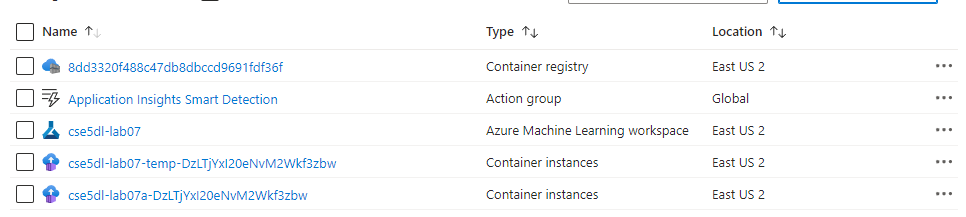

In [ ]:
# This call triggers deployment but doesn't wait for it to finalise
service = Model.deploy(
    workspace=workspace,
    name='cse5dl-lab07a',
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True)

# Wait for deployment to complete
service.wait_for_deployment(show_output=True)

If successful, you should see the following from the log above:

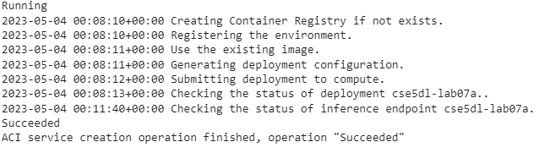

This means the web service is live! To see its web address, run the below cell. You'll see a path which ends with `/score` - this is where prediction requests should be sent.

In [ ]:
print(service.scoring_uri)

### Test the Endpoint
With the server running, we can make a HTTP request and check that the response is what we expect. If you visit the link, you should consistently see a web page which says "Positive" or "Negative" - this is what happens when the model is fed an empty string as input.

Visiting a web page performs a GET request; in order to pass a string to the model, we need to perform a POST request - which will require a little code.

<font color="red">Run the below cell to perform inference using your remote machine learning model.</font>

In [ ]:
import requests
import json

def predict(input_str):
    # Make a post request at our specified URI with the input string
    resp = requests.post(url=service.scoring_uri,
                         json=input_str)
    # Decode the response from json to a regular string
    sentiment = resp.json()
    return sentiment

print(predict("Dow Jones plummets two points amid union strikes"))
print(predict("Market improves for third day in a row"))

### Starting a Web Server
You now have a functional model accessible via the web - great!

To make the prediction process a little nicer, we're going to start a basic web server. This will serve a single HTML file with an interface for making model predictions.

We can run a server on a given port (e.g 5000) using the google colab script given below which runs the python script `webserver.py` to start the server. Before running the next cell, open the `webserver.py` file and read through it. The comments should be quite helpful.

<font color="red">Run the next cell to start the interface web server. Once it's started, visit the first address printed below.</font>

In [ ]:
import webserver
from google.colab.output import eval_js

print(eval_js("google.colab.kernel.proxyPort(5000)"))
webserver.start(service.scoring_uri)

### Clean Up
__Important:__ After trying out the model a few times using the web interface, it's time to shut down and deprovision our resources. If you don't do this, you will use up your free credits.


We'll do this via the Azure web interface, so visit [the portal](https://portal.azure.com), and click on "Resource Groups" - next to the subscriptions button you clicked earlier. There, you should find your cse5dl resource group - click on that to enter it.

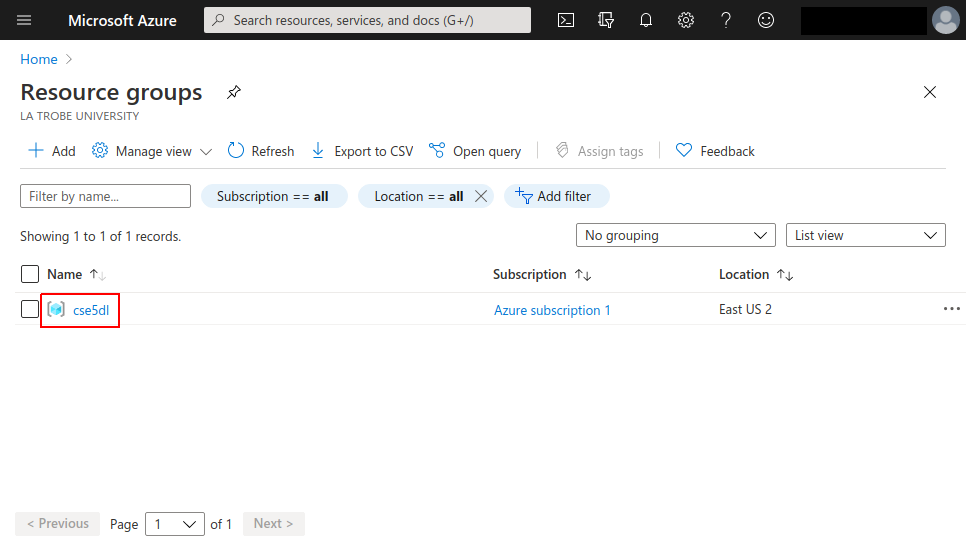

To the bottom right of this screen you'll see a list of resources, including a Container Registry and Machine Learning.

A Docker image was built during deployment, so we could pull that image from Container Registry and use it locally if we desired. This is outside the scope of this lab, but feel free to look around if you're interested.

Before we clean up, we will have a look at the Machine Learning space. Click the name of the Machine Learning space to open it.

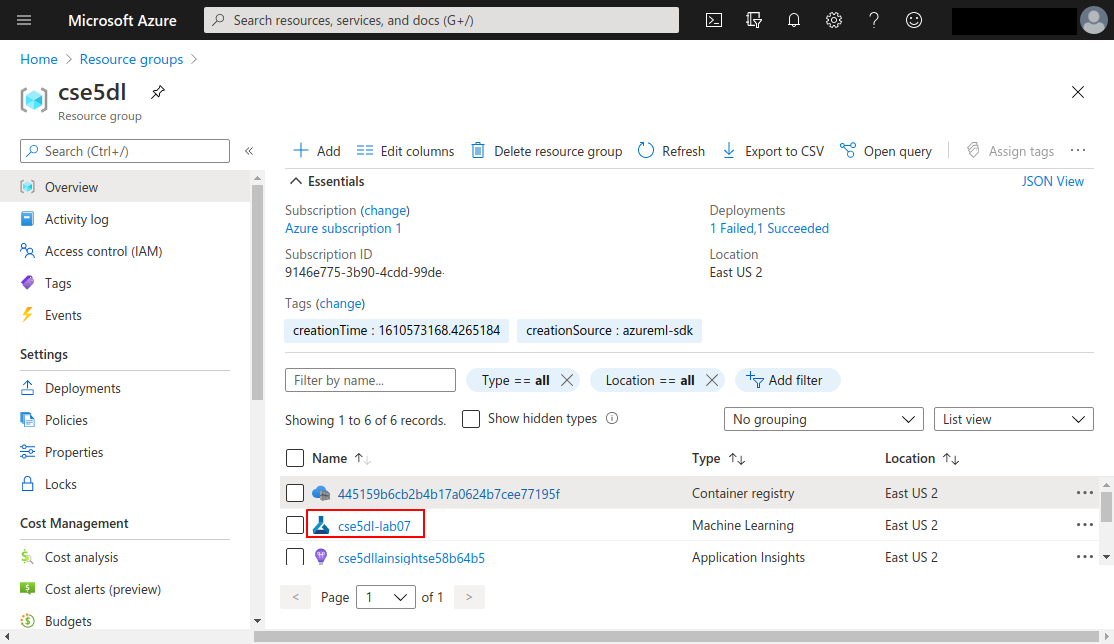

The page we're presented with contains metadata about our Machine Learning resource; click the "Studio web URL" on the top right to visit the studio.

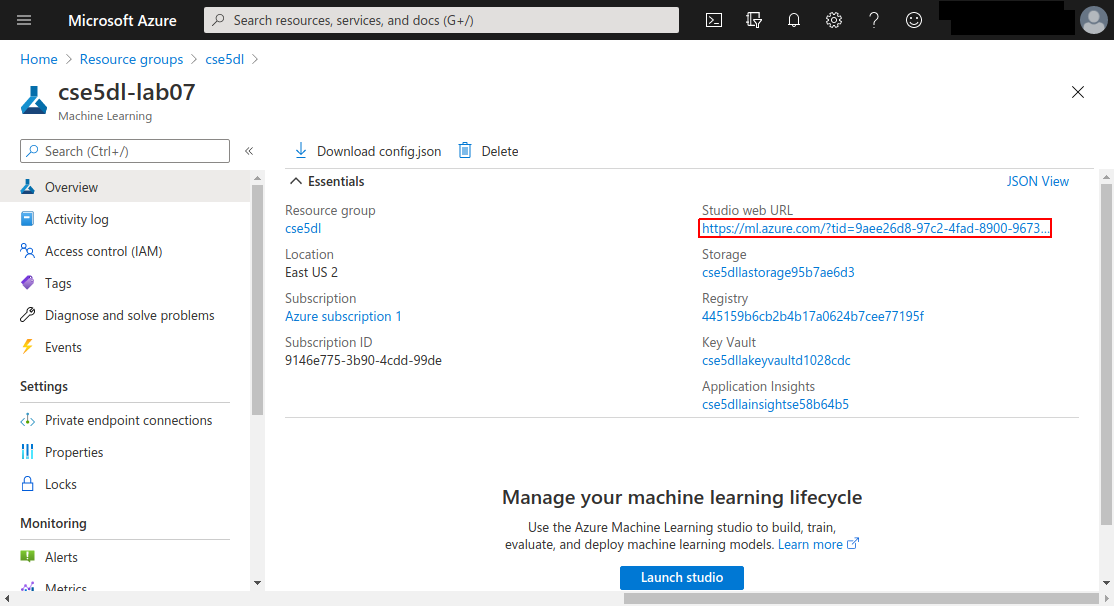

Take a few minutes to look around the interface, as is this is where we would house all of our models, experiment information and datasets - you can even run Notebooks using our provisioned resources!

Click on the models and endpoints tabs on the left to see the resources we created. Then, return to the cse5dl resource group using the same instructions as before.

Time to finally delete the resource group and all of its contained resources. Although we can delete the resources individually, we'll delete everything in one step. Click the "Delete resource group" button to open the confirmation dialog.

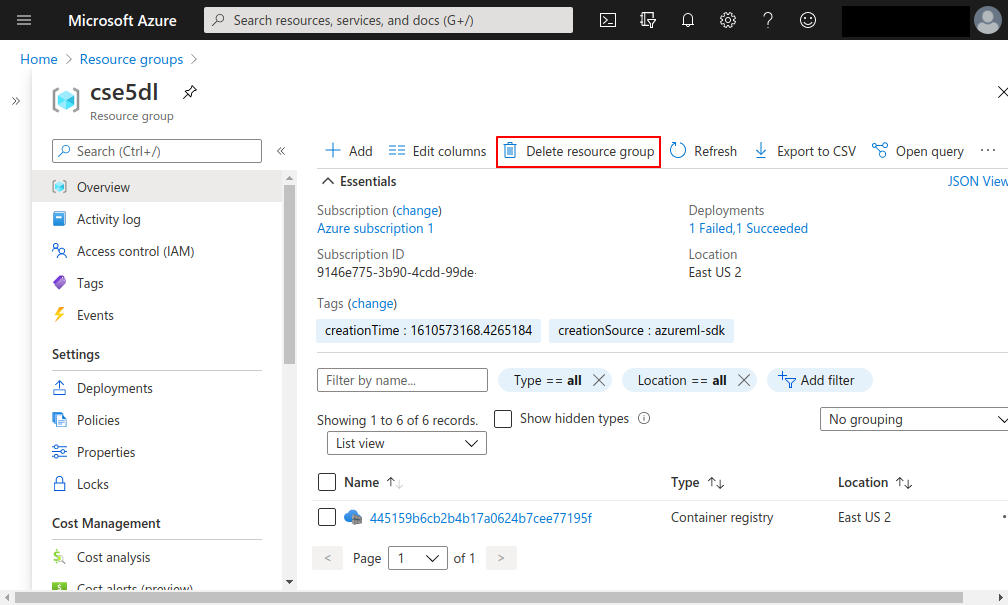

To confirm and begin deletion, type the name of the resource group "cse5dl" into the text box and click "delete". This will take a few minutes to process, so it's best wait until you're given confirmation before exiting.

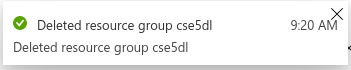

After confirmation, click the person icon on the top right and click "Sign out".

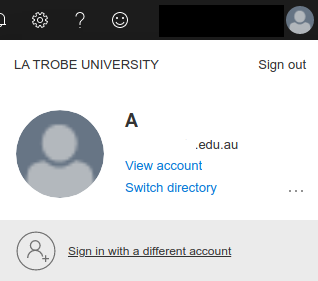

That's it! You've successfully provisioned resources and started a machine learning prediction server, then shut down and deprovisioned again like you were never there. Although it's a slow process, it's much faster than managing your own servers, and Azure provides advanced mechanisms (which we won't explore here) to automatically scale resources based on demand.